### Feature importance analysis

After extracting several features for each journal, we are interested to know which features are more important for each cluster. We use one methods to do that we train a classifier.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pathlib
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

### Loading Data
We load the data we will be using for the classification. To generate the journals features we combine two datasets that were previously computed : journal_attributes (attributes of the journal extracted from wikidata), journal semantic (percentage of words related to the given lexical categories in the journal quotes).

In [26]:
quotebanks = Path('/content/drive/MyDrive/Quotebank')
save = Path('/content/drive/MyDrive/Quotebank')
journal_attributes = pd.read_json(save/'journal_attributes.json')
print(journal_attributes.shape)
journal_attributes.head(4)

(5734, 20)


,instance of,part of,genre,original broadcaster,country,country of origin,owned by,headquaters location,inception_year,newspaper format,language of work,industry,employees,publisher,is located in,field of work,sport,description,journal_label,journal_id
1011now.com,[Q1616075],[],[],[],[Q30],[],[],[Q28260],[1953],[],[],[],[],[],[],[],[],"[CBS television affiliate in Lincoln, Nebraska...",[KOLN],[Q6334998]
1070thefan.com,[Q14350],[],[],[],[Q30],[],[Q5373589],[],[2007],[],[],[],[],[],[Q1415],[],[],[radio station from Indianapolis],[WFNI],[Q7949418]
107jamz.com,[Q14350],[],[],[],[Q30],[],[Q7830269],[],[],[],[],[],[],[],[Q1588],[],[],[Urban contemporary radio station in Lake Arth...,[KJMH],[Q6331512]
10news.com,[Q1616075],[],[],[],[Q30],[],[Q283457],[Q16552],"[1953, 1997]",[],[],[],[],[],[],[],[],"[channel 10 television station in San Diego, C...","[KGTV, KZSD-LP]","[Q3191396, Q16931724]"


In [27]:
journals_semantic = pd.read_csv(save/'journals-semantic-NORMED.csv.bz2', index_col=0)
print(journals_semantic.shape)
journals_semantic.head(4)

(5734, 38)


,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,art,computer,real_estate,home,sexual,fiction,business,cooking,religion,internet,eating,sports,love,weather,music,vehicle,science,work,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id
1011now.com,0.229504,0.215160,0.243848,0.071720,0.100408,0.021516,0.043032,0.028688,0.136268,0.064548,0.086064,0.043032,0.186472,0.186472,0.000000,0.000000,0.559417,0.050204,0.050204,0.050204,0.064548,0.143440,0.078892,0.028688,0.078892,0.064548,0.064548,0.372944,0.028688,0.243848,0.028688,0.193644,0.272536,0.021516,0.200816,0.014344,0.043032,-1.0
1070thefan.com,0.159617,0.133014,0.026603,0.079809,0.026603,0.000000,0.053206,0.053206,0.000000,0.000000,0.053206,0.026603,0.000000,0.053206,0.000000,0.000000,0.372441,0.000000,0.000000,0.026603,0.053206,0.691675,0.133014,0.000000,0.133014,0.026603,0.079809,0.372441,0.212823,0.239426,0.000000,0.133014,0.106412,0.026603,0.000000,0.053206,0.000000,-1.0
107jamz.com,0.165549,0.090300,0.090300,0.210699,0.030100,0.075250,0.045150,0.060200,0.180599,0.105350,0.240799,0.060200,0.105350,0.210699,0.090300,0.000000,0.376248,0.015050,0.030100,0.090300,0.030100,0.120399,0.300999,0.045150,0.481598,0.000000,0.015050,0.210699,0.225749,0.165549,0.090300,0.165549,0.210699,0.015050,0.120399,0.105350,0.105350,6.0
10news.com,0.227248,0.261436,0.233281,0.102563,0.136751,0.024133,0.054298,0.040221,0.142784,0.110607,0.064353,0.084464,0.172950,0.158872,0.036199,0.004022,0.514827,0.070386,0.040221,0.092508,0.072398,0.134740,0.132729,0.038210,0.064353,0.038210,0.076420,0.241325,0.070386,0.170939,0.046254,0.235292,0.404220,0.022121,0.203115,0.028155,0.030166,14.0


### Data preprocessing

We begin preprocessing by journal_attributes, its features will necessitate the most time. We drop three columns journal_id, journal_label, description. Journal_id and journal_label identify uniquely each journal, thus not usefull for classification. We could extract some information from the description (ex location, journal kind if not specified in the other fields), but it would not be trivial and we have already enough information to obtain good result. 

In [28]:
###the columns we will not use for classification
useless = ['journal_id', 'journal_label', 'description']
journal_attributes.drop(columns=useless, inplace=True)
journal_attributes.head(4)

,instance of,part of,genre,original broadcaster,country,country of origin,owned by,headquaters location,inception_year,newspaper format,language of work,industry,employees,publisher,is located in,field of work,sport
1011now.com,[Q1616075],[],[],[],[Q30],[],[],[Q28260],[1953],[],[],[],[],[],[],[],[]
1070thefan.com,[Q14350],[],[],[],[Q30],[],[Q5373589],[],[2007],[],[],[],[],[],[Q1415],[],[]
107jamz.com,[Q14350],[],[],[],[Q30],[],[Q7830269],[],[],[],[],[],[],[],[Q1588],[],[]
10news.com,[Q1616075],[],[],[],[Q30],[],[Q283457],[Q16552],"[1953, 1997]",[],[],[],[],[],[],[],[]


The second step is to select one value per features and to remove categories that don't have enough appearances. After a short analysis we clearly see that we will not be able do it manually.

In [29]:
from collections import Counter
def count_columns_value(col):
  values = [x for x in col.values if type(x)==list]
  counter = Counter([y for x in values for y in x])
  return counter


In [30]:
#number of fields with more than one values
col_statistics = pd.DataFrame()
col_statistics['more than one value']=journal_attributes.apply(lambda col: col.apply(lambda x: 1 if len(x)>1 else 0), axis=0).sum(axis=0)
col_statistics['unique values'] = journal_attributes.apply(lambda col: len(count_columns_value(col)), axis=0)
col_statistics

,more than one value,unique values
instance of,1136,2293
part of,119,1092
genre,83,679
original broadcaster,41,260
country,129,203
country of origin,114,103
owned by,184,1022
headquaters location,152,1053
inception_year,512,316
newspaper format,18,16


In [31]:
for col in journal_attributes.columns:
  top_20 = count_columns_value(journal_attributes[col]).most_common(20)
  print(f' \'{col}\' top 20 categories : {sorted(top_20, key=lambda x:x[1], reverse=True)}')
  print()

 'instance of' top 20 categories : [('Q11032', 858), ('Q35127', 451), ('Q41298', 409), ('Q1616075', 333), ('Q14350', 312), ('Q5', 257), ('Q1110794', 192), ('Q1002697', 188), ('Q43229', 169), ('Q4830453', 163), ('Q163740', 134), ('Q5633421', 125), ('Q1153191', 86), ('Q738377', 86), ('Q5398426', 85), ('Q17232649', 80), ('Q737498', 78), ('Q618779', 77), ('Q3918', 74), ('Q2085381', 73)]

 'part of' top 20 categories : [('Q184478', 7), ('Q639738', 6), ('Q131626', 4), ('Q934745', 4), ('Q7072326', 4), ('Q291831', 4), ('Q925668', 4), ('Q594428', 4), ('Q747915', 3), ('Q278064', 3), ('Q54837', 3), ('Q276', 3), ('Q16900659', 3), ('Q13371', 3), ('Q901553', 3), ('Q242345', 3), ('Q592248', 2), ('Q1452194', 2), ('Q3944788', 2), ('Q11211', 2)]

 'genre' top 20 categories : [('Q637866', 74), ('Q182415', 29), ('Q7603925', 25), ('Q93204', 25), ('Q622812', 21), ('Q40831', 17), ('Q130232', 16), ('Q85133165', 16), ('Q1366112', 15), ('Q1358344', 13), ('Q22812458', 13), ('Q213051', 13), ('Q9397629', 13), ('Q8

We choose the following heuristic to select the values of categorical features. First we keep only categories with more than 25 apperances (less than one percent of all the journal have the same category) and that are in the top 15 most common category. It seems a good trade off after analysing the top 20 most common categories. If a field has still more than 2 values after this first selection, we choose the least common category to try to increase diversity. We do not explore further for lack of time and because our results are sufficients. Remark for inception year, the only ordinal column we only keep fields with only one value for simplicity.

In [32]:
###this categories are manually removed from instance of column as not pertinant ex Q5 : human
not_considered_categories = ['Q5398426', 'Q43229', 'Q163740', 'Q4830453', 'Q5']

def select_columns_value(counter):
  cut = 25
  # we keep only categories in top 15 most common and with more than 30 occurences
  selected = map(lambda x: x[0], filter(lambda x:x[1]>cut,counter.most_common(15)))
  selected = filter(lambda x: x not in not_considered_categories ,selected)
  return list(selected)

def select_value(fields, selected_values, counter):
  #we select categories with minimum occurences
  field = min(filter(lambda x: x in selected_values, fields), key=lambda x: counter[x], default=None)
  return field 

###we keep only one value per field
def process_column(col):
  counter = count_columns_value(col)
  selected = select_columns_value(counter)

  col = col.apply(lambda x: select_value(x, selected, counter))
  return col

In [33]:
for col in journal_attributes.columns:
  if col != 'inception_year':
    journal_attributes[col] = process_column(journal_attributes[col])
  else:
    journal_attributes[col] = journal_attributes[col].apply(lambda x: int(x[0]) if len(x)==1 else np.nan)
journal_attributes.head(5)

,instance of,part of,genre,original broadcaster,country,country of origin,owned by,headquaters location,inception_year,newspaper format,language of work,industry,employees,publisher,is located in,field of work,sport
1011now.com,Q1616075,None,None,None,Q30,None,None,None,1953.0,None,None,None,None,None,None,None,None
1070thefan.com,Q14350,None,None,None,Q30,None,None,None,2007.0,None,None,None,None,None,None,None,None
107jamz.com,Q14350,None,None,None,Q30,None,Q7830269,None,NaN,None,None,None,None,None,None,None,None
10news.com,Q1616075,None,None,None,Q30,None,None,None,NaN,None,None,None,None,None,None,None,None
1130thetiger.com,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None


In [34]:
categorical_col = [col for col in journal_attributes.columns if col!='inception_year']
ordinal_col = ['inception_year']

journal_attributes[categorical_col].describe()

,instance of,part of,genre,original broadcaster,country,country of origin,owned by,headquaters location,newspaper format,language of work,industry,employees,publisher,is located in,field of work,sport
count,2475,0,102,0,1888,1201,96,239,642,1269,86,65,0,95,28,100
unique,10,0,2,0,7,5,3,4,3,4,2,1,0,3,1,3
top,Q11032,NaN,Q637866,NaN,Q30,Q30,Q16998932,Q60,Q665319,Q1860,Q11030,QNone,NaN,Q61,Q413,Q2736
freq,642,NaN,73,NaN,1342,847,34,92,331,1171,55,65,NaN,36,28,39


In [35]:
journal_attributes[ordinal_col].describe()

,inception_year
count,2073.000000
mean,1955.163531
std,52.694673
min,1660.000000
25%,1922.000000
50%,1970.000000
75%,1999.000000
max,2016.000000


We choose to keep only 'instance of', 'country', 'headquaters location', 'inception_year', 'newspaper format', 'language of work', 'sport' as they are the only columns with more than 100 non missing values and more than 2 category. We don't keep 'country of origin', because it is redudant with 'country'. We also take in account the relevance of the categories when making our choice.

In [36]:
to_remove = ['part of', 'genre', 'original broadcaster', 'country of origin', 'owned by', 'employees', 'publisher', 'industry', 'is located in', 'field of work']
categorical_col = [cat for cat in categorical_col if cat not in to_remove]
journal_attributes.drop(columns=to_remove, inplace=True)
journal_attributes.head(4)

,instance of,country,headquaters location,inception_year,newspaper format,language of work,sport
1011now.com,Q1616075,Q30,None,1953.0,None,None,None
1070thefan.com,Q14350,Q30,None,2007.0,None,None,None
107jamz.com,Q14350,Q30,None,NaN,None,None,None
10news.com,Q1616075,Q30,None,NaN,None,None,None


We transfom each QID to an understandable label.

In [37]:
for col in journal_attributes.columns:
  if col in categorical_col:
    print(f' \'{col}\' categories : {set(journal_attributes[col].values)}')
    print()

 'instance of' categories : {'Q1153191', 'Q41298', 'Q1616075', 'Q5633421', 'Q1110794', 'Q11032', 'Q738377', 'Q14350', 'Q35127', None, 'Q1002697'}

 'country' categories : {'Q408', 'Q27', 'Q30', 'Q16', 'Q142', 'Q668', None, 'Q145'}

 'headquaters location' categories : {'Q62', 'Q60', 'Q61', 'Q84', None}

 'newspaper format' categories : {'Q665319', 'Q3684950', 'Q1449648', None}

 'language of work' categories : {'Q7976', 'Q1860', 'Q1321', 'Q150', None}

 'sport' categories : {'Q41323', 'Q5372', None, 'Q2736'}



In [38]:
def transform_qid_to_label(df, labels):
  for col in df.columns:

    df[col] = df[col].apply(lambda x : labels.get(x,x))
  return df

labels = {'Q1616075': 'television station',
          'Q14350' : 'radio station',
          'Q35127' : 'website',
          'Q41298' : 'magazine',
          'Q5398426' : None,
          'Q43229' : None,
          'Q5633421' : 'Scientific journal',
          'Q163740' : None,
          'Q11032' : 'newspaper',
          'Q1110794' : 'newspaper',
          'Q4830453' : None,
          'Q5' : None,
          'Q1002697' : 'newspaper',
          'Q1153191' : 'newspaper',
          'Q738377': 'student newspaper',
          'Q27' :'Ireland',
          'Q142' : 'France',
          'Q30': 'USA',
          'Q408' : 'Australia',
          'Q16' : 'Canada',
          'Q145': 'UK',
          'Q668' : 'India',
          'Q62' : 'San Francisco',
          'Q61' : 'Washington',
          'Q60' : 'New York',
          'Q84' : 'London', 
          'Q665319' : 'broadsheet',
          'Q1449648' : 'tabloid',
          'Q3684950': 'Cradle',
          'Q1860' : 'English',
          'Q7976' : 'English',
          'Q150' : 'French' ,
          'Q1321' : 'Spanish',
          'Q41323' : 'American football',
          'Q2736' : 'Football',
          'Q5372' : 'Basketball'}


In [39]:
journal_attributes = transform_qid_to_label(journal_attributes, labels)
journal_attributes.head(4)

,instance of,country,headquaters location,inception_year,newspaper format,language of work,sport
1011now.com,television station,USA,None,1953.0,None,None,None
1070thefan.com,radio station,USA,None,2007.0,None,None,None
107jamz.com,radio station,USA,None,NaN,None,None,None
10news.com,television station,USA,None,NaN,None,None,None


We append the semantic features and plot distributions and analyse their distribution. Remark, the features were normalised when creating the dataset and they are meaninfully comparable to each other.

In [40]:
continious_col = [col for col in journals_semantic.columns if col!='cluster_id']
journal_attributes = journal_attributes.merge(journals_semantic, left_index=True, right_index=True)
journal_attributes.head(4)

,instance of,country,headquaters location,inception_year,newspaper format,language of work,sport,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,art,computer,real_estate,home,sexual,fiction,business,cooking,religion,internet,eating,sports,love,weather,music,vehicle,science,work,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id
1011now.com,television station,USA,None,1953.0,None,None,None,0.229504,0.215160,0.243848,0.071720,0.100408,0.021516,0.043032,0.028688,0.136268,0.064548,0.086064,0.043032,0.186472,0.186472,0.000000,0.000000,0.559417,0.050204,0.050204,0.050204,0.064548,0.143440,0.078892,0.028688,0.078892,0.064548,0.064548,0.372944,0.028688,0.243848,0.028688,0.193644,0.272536,0.021516,0.200816,0.014344,0.043032,-1.0
1070thefan.com,radio station,USA,None,2007.0,None,None,None,0.159617,0.133014,0.026603,0.079809,0.026603,0.000000,0.053206,0.053206,0.000000,0.000000,0.053206,0.026603,0.000000,0.053206,0.000000,0.000000,0.372441,0.000000,0.000000,0.026603,0.053206,0.691675,0.133014,0.000000,0.133014,0.026603,0.079809,0.372441,0.212823,0.239426,0.000000,0.133014,0.106412,0.026603,0.000000,0.053206,0.000000,-1.0
107jamz.com,radio station,USA,None,NaN,None,None,None,0.165549,0.090300,0.090300,0.210699,0.030100,0.075250,0.045150,0.060200,0.180599,0.105350,0.240799,0.060200,0.105350,0.210699,0.090300,0.000000,0.376248,0.015050,0.030100,0.090300,0.030100,0.120399,0.300999,0.045150,0.481598,0.000000,0.015050,0.210699,0.225749,0.165549,0.090300,0.165549,0.210699,0.015050,0.120399,0.105350,0.105350,6.0
10news.com,television station,USA,None,NaN,None,None,None,0.227248,0.261436,0.233281,0.102563,0.136751,0.024133,0.054298,0.040221,0.142784,0.110607,0.064353,0.084464,0.172950,0.158872,0.036199,0.004022,0.514827,0.070386,0.040221,0.092508,0.072398,0.134740,0.132729,0.038210,0.064353,0.038210,0.076420,0.241325,0.070386,0.170939,0.046254,0.235292,0.404220,0.022121,0.203115,0.028155,0.030166,14.0


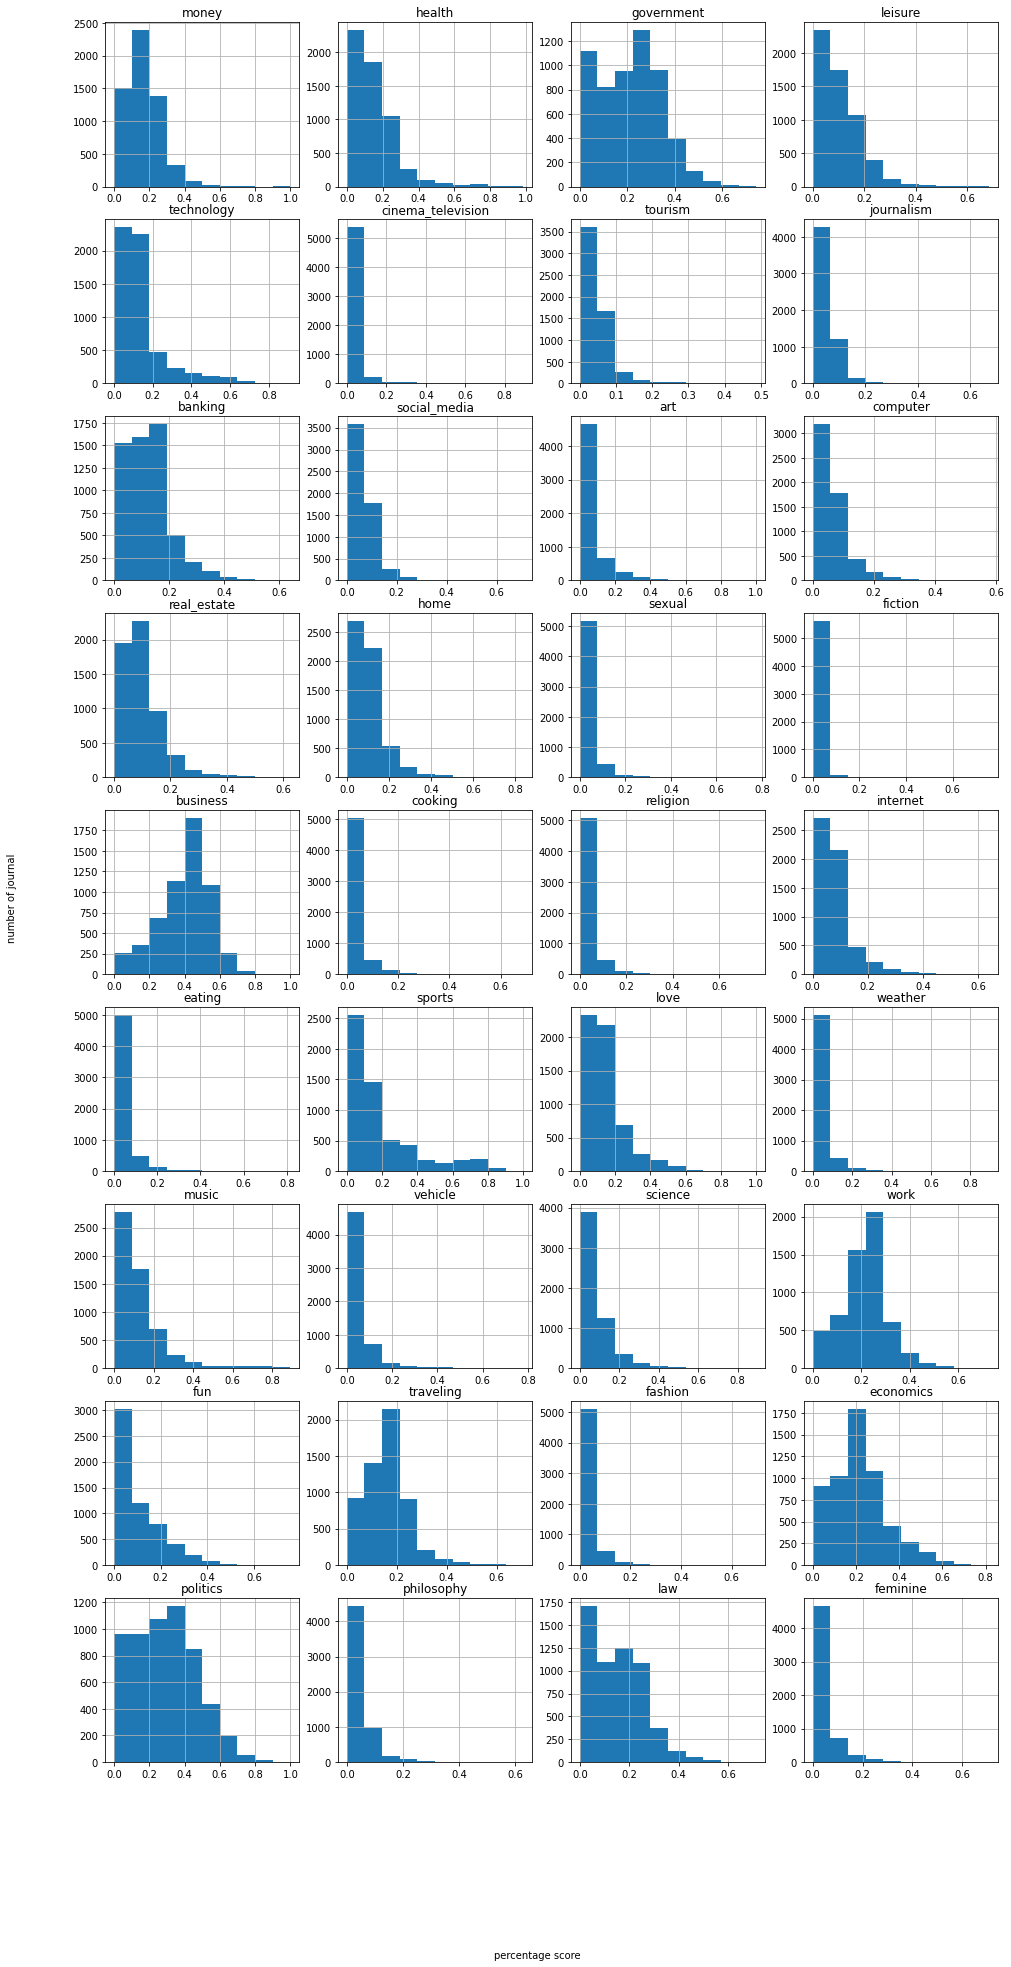

In [41]:
fig, axs = plt.subplots(nrows=9, ncols=4, figsize=(16,32))

fig.text(0.5, 0.04, 'percentage score', ha='center')
fig.text(0.04, 0.5, 'number of journal', va='center', rotation='vertical')

for col, ax in zip(continious_col, axs.flatten()):
  ax.set_title(col)
  journal_attributes[col].hist(ax=ax)



### Finding features importances

We copy the feature, transform categorical features to one hot encoding, replace Nans in 'inception year' by zeros (seems to work). We don't normalize the feautres as continous features were already normalize during the extraction and are meaningully comparable and it would not make really sense to normalise one hot encoding. We obtain good results with this setup.

In [42]:
features = journal_attributes.copy()
features.fillna(0, inplace=True)
features = pd.get_dummies(features, columns=categorical_col, drop_first=True)

features_col = [col for col in features.columns if col!='cluster_id']
features.head(4)

,inception_year,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,art,computer,real_estate,home,sexual,fiction,business,cooking,religion,internet,eating,sports,love,weather,music,vehicle,science,work,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id,instance of_Scientific journal,instance of_magazine,instance of_newspaper,instance of_radio station,instance of_student newspaper,instance of_television station,instance of_website,country_Australia,country_Canada,country_France,country_India,country_Ireland,country_UK,country_USA,headquaters location_London,headquaters location_New York,headquaters location_San Francisco,headquaters location_Washington,newspaper format_Cradle,newspaper format_broadsheet,newspaper format_tabloid,language of work_English,language of work_French,language of work_Spanish,sport_American football,sport_Basketball,sport_Football
1011now.com,1953.0,0.229504,0.215160,0.243848,0.071720,0.100408,0.021516,0.043032,0.028688,0.136268,0.064548,0.086064,0.043032,0.186472,0.186472,0.000000,0.000000,0.559417,0.050204,0.050204,0.050204,0.064548,0.143440,0.078892,0.028688,0.078892,0.064548,0.064548,0.372944,0.028688,0.243848,0.028688,0.193644,0.272536,0.021516,0.200816,0.014344,0.043032,-1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1070thefan.com,2007.0,0.159617,0.133014,0.026603,0.079809,0.026603,0.000000,0.053206,0.053206,0.000000,0.000000,0.053206,0.026603,0.000000,0.053206,0.000000,0.000000,0.372441,0.000000,0.000000,0.026603,0.053206,0.691675,0.133014,0.000000,0.133014,0.026603,0.079809,0.372441,0.212823,0.239426,0.000000,0.133014,0.106412,0.026603,0.000000,0.053206,0.000000,-1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
107jamz.com,0.0,0.165549,0.090300,0.090300,0.210699,0.030100,0.075250,0.045150,0.060200,0.180599,0.105350,0.240799,0.060200,0.105350,0.210699,0.090300,0.000000,0.376248,0.015050,0.030100,0.090300,0.030100,0.120399,0.300999,0.045150,0.481598,0.000000,0.015050,0.210699,0.225749,0.165549,0.090300,0.165549,0.210699,0.015050,0.120399,0.105350,0.105350,6.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10news.com,0.0,0.227248,0.261436,0.233281,0.102563,0.136751,0.024133,0.054298,0.040221,0.142784,0.110607,0.064353,0.084464,0.172950,0.158872,0.036199,0.004022,0.514827,0.070386,0.040221,0.092508,0.072398,0.134740,0.132729,0.038210,0.064353,0.038210,0.076420,0.241325,0.070386,0.170939,0.046254,0.235292,0.404220,0.022121,0.203115,0.028155,0.030166,14.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

After many trials, we select features importance as follows. For each cluster, we samples (with replacement) points in the cluser and out of the cluster such to have a balance dataset of sufficient size. Then, we train a logistic classifier on it and we use the coefficients as features importances for the cluster. 

Remark : we do not use statsmodels to compute the logistic regression as the features matrix is often singular and statsmodel cannot solve such matrix. We could also use classification to evluate quality of our clusters.

In [44]:
def feature_importance(cluster, features):
  X, y = balance_classes(features, cluster)
  imp_logit = feature_importance_logistic(X, y)
  return imp_logit
 

def balance_classes(features, cluster):
  in_cluster = features[features.cluster_id==cluster]
  out_cluster = features[features.cluster_id!=cluster]

  min_size = min(len(in_cluster), len(out_cluster))
  size = min(800,3*min_size)

  in_cluster = in_cluster.sample(size, replace=True, random_state=42)
  out_cluster = out_cluster.sample(size, replace=True, random_state=42)
  merged = in_cluster.append(out_cluster)

  return  merged.drop(columns=['cluster_id']), ( merged.cluster_id==cluster)

def feature_importance_tree(X, y):
  clf = RandomForestClassifier(n_estimators=500)
  clf.fit(X, y)
  imp =  clf.feature_importances_
  std =  np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
  return pd.DataFrame([imp], columns=X.columns)

def feature_importance_xgboost(X, y):
  clf = XGBClassifier(n_estimators=500)
  clf.fit(X, y)
  imp =  clf.feature_importances_
  return pd.DataFrame([imp], columns=X.columns)

def feature_importance_logistic(X, y):
  logit = LogisticRegression(max_iter=10000)
  logit.fit(X,y)
  return pd.DataFrame(data=logit.coef_, columns=X.columns)




In [45]:
feat_importance = pd.DataFrame(columns=[ col for col in features.columns if col!='cluster_id'])
for id in range(15):
  imp_logit = feature_importance(id, features)
  feat_importance = feat_importance.append(imp_logit)

feat_importance.set_index(pd.Index(range(15)),inplace=True)
feat_importance

,inception_year,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,art,computer,real_estate,home,sexual,fiction,business,cooking,religion,internet,eating,sports,love,weather,music,vehicle,science,work,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,instance of_Scientific journal,instance of_magazine,instance of_newspaper,instance of_radio station,instance of_student newspaper,instance of_television station,instance of_website,country_Australia,country_Canada,country_France,country_India,country_Ireland,country_UK,country_USA,headquaters location_London,headquaters location_New York,headquaters location_San Francisco,headquaters location_Washington,newspaper format_Cradle,newspaper format_broadsheet,newspaper format_tabloid,language of work_English,language of work_French,language of work_Spanish,sport_American football,sport_Basketball,sport_Football
0,0.000021,0.045833,-1.117011,-1.479019,1.303266,2.892886,0.156006,-0.277435,-0.313427,-0.646779,0.766679,0.608325,1.059034,-0.578861,-0.224215,-0.083727,0.485954,1.207941,-0.459850,0.122441,0.483948,-0.556052,-1.017074,1.203080,-0.085580,1.208824,-0.113449,0.459746,0.664887,0.544135,-0.400766,0.462337,0.424951,-0.931726,0.207945,-1.140224,-0.194424,0.081988,-0.641233,-0.415265,-0.530463,-0.469606,-0.403234,-0.275928,0.670868,-0.206220,-0.739683,-0.220070,0.000000,0.000000,-0.520899,-1.693969,-0.218328,0.000000,-0.038727,-0.220070,-0.385254,-0.336124,-0.652634,0.766010,0.000000,0.993396,0.000000,0.000000,0.000000
1,-0.000040,-0.340727,0.032380,0.863421,-0.688691,-0.147439,-0.062736,0.083746,-0.088345,0.147699,-0.148546,-0.138085,-0.562517,-0.321093,0.357440,1.716554,0.121372,-1.623318,0.291171,4.300526,-0.010922,0.783087,-0.964808,1.634488,1.329795,-0.293477,-0.316937,-0.322311,-1.505819,-0.922987,-0.674608,-0.522162,0.347526,0.709316,1.322154,-0.087404,-0.535190,0.294743,0.953531,-0.066392,0.188705,-0.891398,-0.141862,-0.609649,0.027477,-0.094093,-0.024293,-0.356633,-0.240795,0.000000,0.129363,-0.100109,0.129780,0.470919,-0.334016,0.000000,-0.353545,-0.391788,-0.603360,0.862310,0.000000,0.000000,0.000000,-0.259554,-0.098103
2,0.000028,0.357922,0.114769,0.615331,0.170214,-0.883660,-0.444388,0.169318,0.108936,0.552313,0.107015,-0.286754,-0.249152,1.078141,0.663148,-0.105706,-0.023213,0.589826,0.072426,-0.634916,0.255629,0.259383,0.368407,0.085045,-0.174283,-0.556383,-0.500368,-0.100608,0.937078,0.474296,0.291897,-0.270681,0.046601,0.891681,-0.233265,-0.265082,-0.517144,0.229301,-0.309030,-0.853482,1.257496,0.909136,-0.080439,-0.569239,-0.724647,-0.640842,-0.358701,-0.539110,0.000000,2.769346,-1.049719,-2.641449,-0.224931,-0.235383,-0.235630,-0.138906,0.350124,0.233753,-0.385689,-1.269337,-0.373933,-0.165177,0.000000,-0.508839,0.000000
3,-0.000065,0.360762,-1.110406,-1.745531,0.224792,-1.810186,-0.805083,0.135313,-0.437646,0.665379,0.046564,-1.474961,-1.323461,-0.353958,-1.131455,-0.200756,0.035725,-0.302260,-0.124098,-0.316246,-0.612774,-0.658853,4.142290,0.290223,-0.601513,1.429728,-0.297720,-0.628237,-0.974607,2.988006,-0.095371,-0.541252,-0.572602,-1.165779,-0.324125,-0.615269,-0.906552,-0.651918,-0.155793,1.229307,-0.414079,0.151629,-0.120371,0.055275,0.144580,-0.550523,-0.425073,0.271407,-0.020850,0.203125,0.363000,-1.320645,-0.936307,-0.199737,0.000000,0.000000,-0.053014,-1.168943,-0.384412,0.557222,-0.263935,0.070959,-0.026696,-0.434774,0.975567
4,-0.000408,0.145830,-1.897936,-1.968947,0.702710,-1.261760,-0.570288,-0.544853,-0.392328,0.035087,-0.587073,0.218137,-0.366190,-0.407122,-0.223912,0.101886,-0.205192,0.161451,-0.245084,-0.506490,-0.128220,-0.101093,2.544012,0.586457,-0.416934,-0.537564,1.484439,-0.294712,0.915204,1.405327,-0.371238,-0.635005,-0.775052,-1.315754,-0.324906,-1.550410,0.312240,-0.283561,-0.284510,0.227814,-1.109063,-0.113273,-0.193175,-0.411306,-0.471929,-0.085490,0.092502,-0.037700,-0.014406,-0.215102,-0.102732,-0.192305,-0.031872,-0.156902,0.626860,-0.122611,0.000000,-0.376700,-

We obtain suprinsingly good results even with the many missing values and the sometimes inacurate field (heuristic). We can interpret the coefficient as divergence from the mean of the dataset. A positive coefficient means that the feature is more present in the cluster than in the rest of the dataset and negative coefficient that the feature is less present.The cluster 0 is about entrainement, video games. We clearly see that with the most important features : technology, leisure. The cluster 6 is about holliwood and celebrites.  We clearly see that with the most important features : love, music, fashion, art. Remark, it is possible that sometimes there is artifact from feature construction. For example, the high coefficients of language_of_work spanish in cluster 0 could come from the fact that most video games website are in several languages and we always select the category with minimum occurences when there is a conflict.

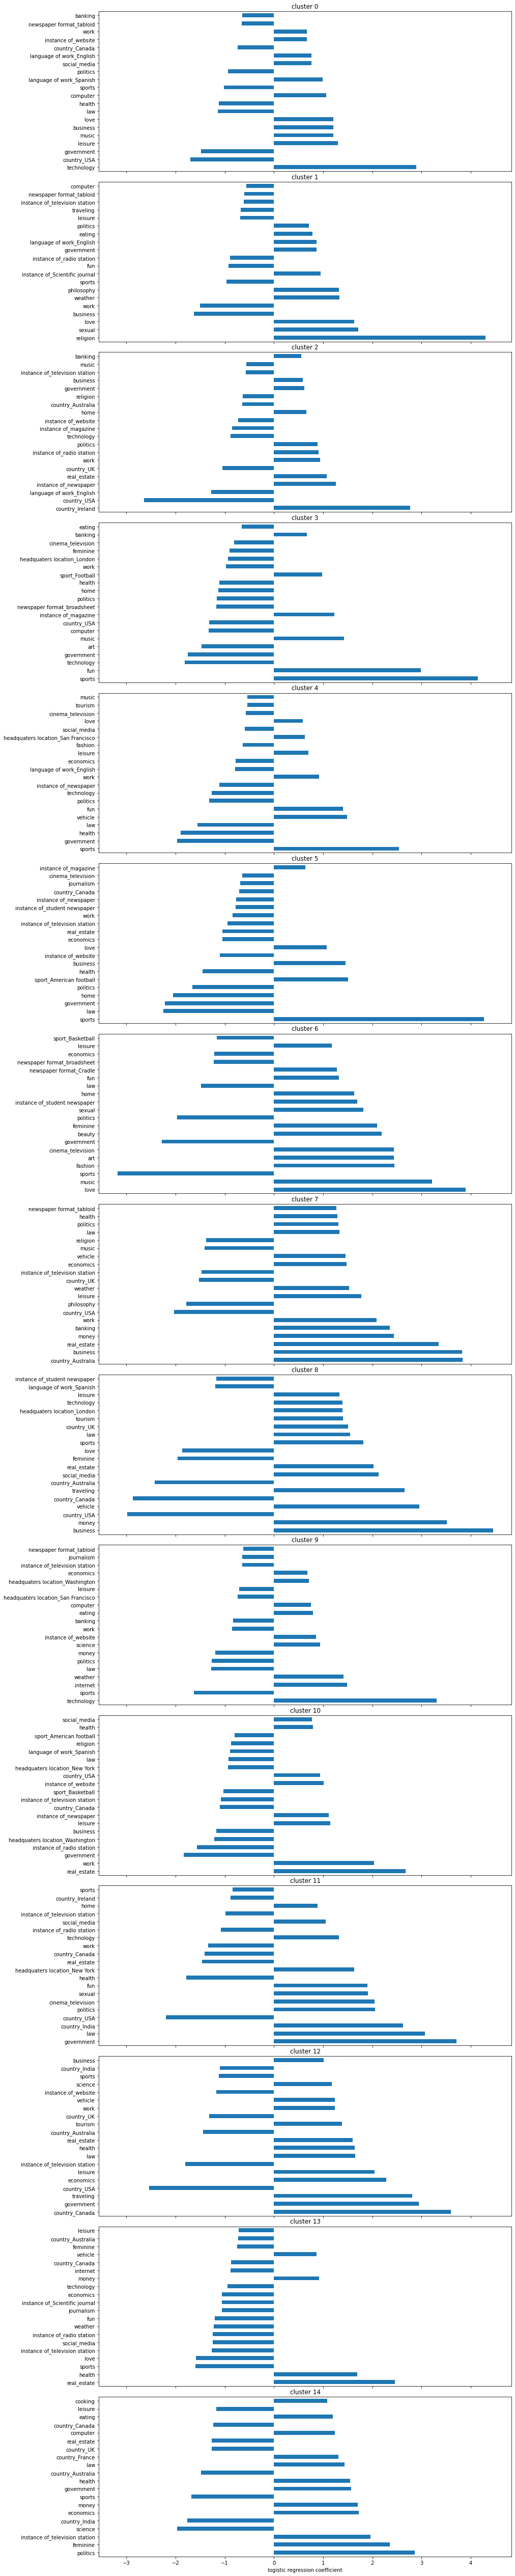

In [46]:
fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(12, 70), sharex=True)

fig.tight_layout()
for ax, data in zip(axs.flatten(), feat_importance.iterrows()):
  cluster_id, series = data
  importance = zip(series.index, series.values)
  sorted_importance = sorted(importance, key=lambda x:abs(x[1]), reverse=True)

  ax.set_title(f"cluster {cluster_id}")
  ax.set_xlabel("logistic regression coefficient")
  pd.Series(dict(sorted_importance))[:20].plot.barh(ax=ax)


In [47]:
feat_importance.to_csv('./feature_importance.csv')